In [353]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

In [354]:
data = pd.read_csv('dataframe/champions.csv')

In [355]:
data['Temporada'] = pd.to_datetime(data['Temporada'])

# Ordenar el DataFrame por la columna 'Temporada'
data = data.sort_values(by='Temporada')

In [356]:
from sklearn.model_selection import train_test_split

# Seleccionar datos de los equipos de interés
equipo_de_interes = [1, 3, 5, 14, 16, 24, 28, 31]
equipo_data = data[data['Local'].isin(equipo_de_interes) | data['Visitante'].isin(equipo_de_interes)]

# Crear una columna que represente si el equipo de interés jugó como local en cada partido
equipo_data['EquipoLocal'] = equipo_data['Local'].apply(lambda x: 1 if x in equipo_de_interes else 0)

# Crear una columna que represente si el equipo de interés jugó como visitante en cada partido
equipo_data['EquipoVisitante'] = equipo_data['Visitante'].apply(lambda x: 1 if x in equipo_de_interes else 0)

# Crear una columna que represente los goles del equipo de interés en cada partido
equipo_data['GolesEquipo'] = equipo_data.apply(lambda row: row['GolesLocal'] if row['EquipoLocal'] == 1 else row['GolesVisitante'], axis=1)

# Seleccionar solo las columnas relevantes
serie_temporal_equipo = equipo_data[['Temporada', 'GolesEquipo']]

# Dividir la serie temporal en conjunto de entrenamiento y prueba
train_data, test_data = train_test_split(serie_temporal_equipo['GolesEquipo'], test_size=0.2, shuffle=False)

# Convertir las fechas a un formato numérico
train_data.index = np.arange(len(train_data))
test_data.index = np.arange(len(train_data), len(train_data) + len(test_data))



/var/folders/98/7bgvzcwx7tz2bgwyh060mq100000gn/T/ipykernel_61873/4201765098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipo_data['EquipoLocal'] = equipo_data['Local'].apply(lambda x: 1 if x in equipo_de_interes else 0)
/var/folders/98/7bgvzcwx7tz2bgwyh060mq100000gn/T/ipykernel_61873/4201765098.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equipo_data['EquipoVisitante'] = equipo_data['Visitante'].apply(lambda x: 1 if x in equipo_de_interes else 0)
/var/folders/98/7bgvzcwx7tz2bgwyh060mq10000

In [357]:
def arima_model(train, test, order):
    # Crear el modelo ARIMA
    model = ARIMA(train, order=order)
    
    # Ajustar el modelo a los datos de entrenamiento
    model_fit = model.fit()
    
    # Predecir los valores futuros
    forecast = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast


In [359]:
modelo_arima, forecast = arima_model(train_data, test_data, order=(0, 1, 1))

forecast

810     2.19928
811     2.19928
812     2.19928
813     2.19928
814     2.19928
         ...   
1008    2.19928
1009    2.19928
1010    2.19928
1011    2.19928
1012    2.19928
Name: predicted_mean, Length: 203, dtype: float64

In [360]:
def evaluacion_modelo(test, forecast):
    errores = test - forecast

    # Métricas de evaluación
    mse = np.mean(errores ** 2)
    mae = np.mean(np.abs(errores))
    rmse = np.sqrt(mse)
    
    # Diccionario con las métricas
    metricas = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }
    
    return metricas

evaluacion_modelo(test_data, forecast)

{'MSE': 2.6034294858162634,
 'MAE': 1.2835202468314633,
 'RMSE': 1.6135146376207015}

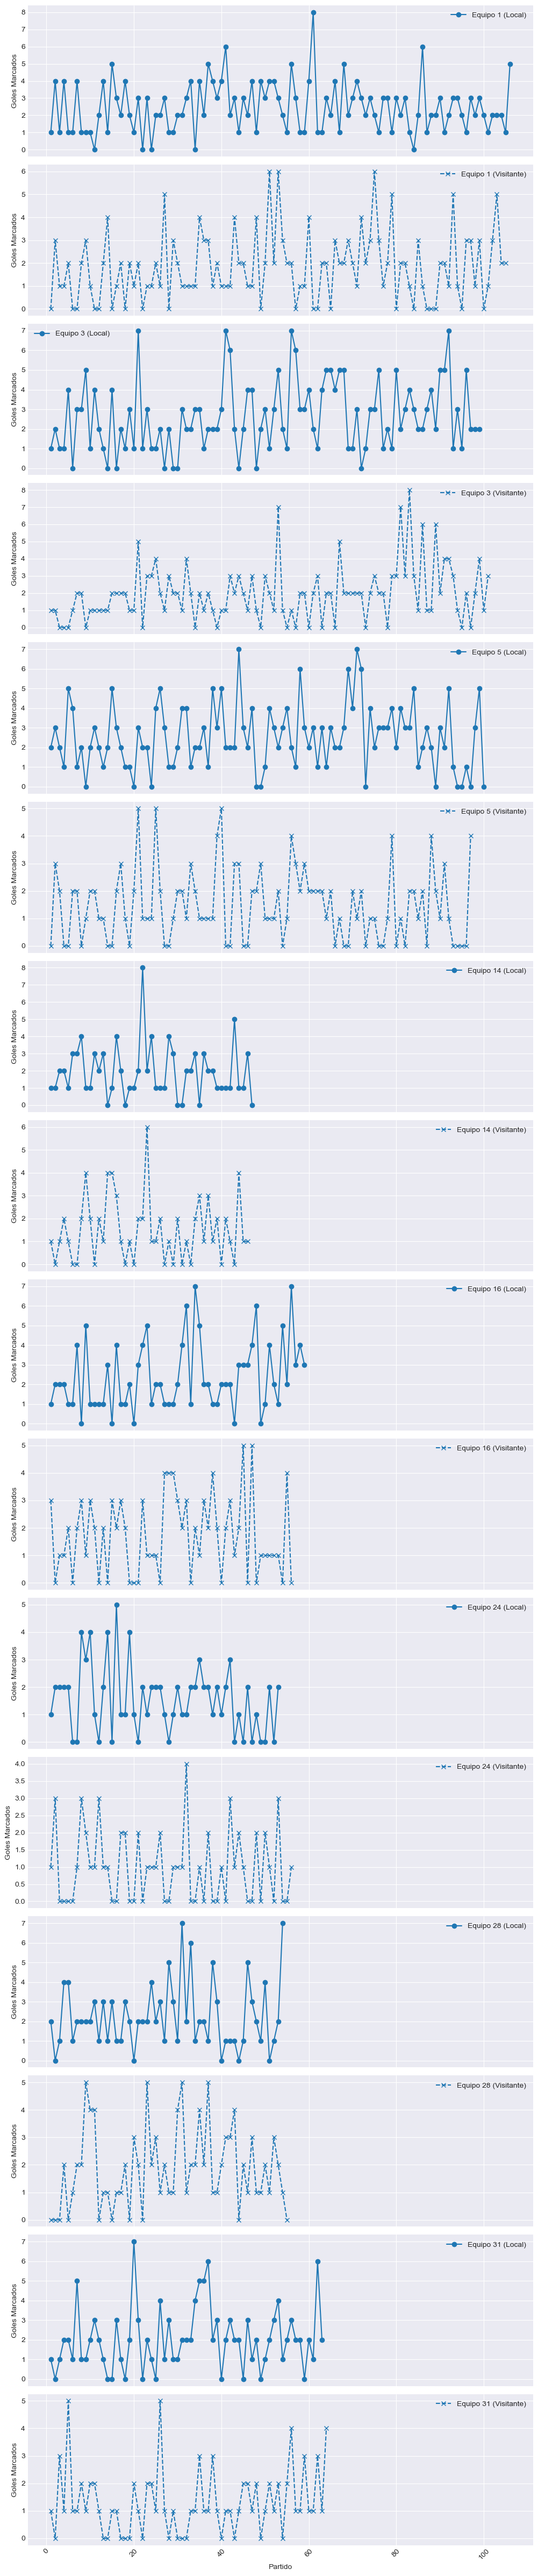

In [361]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear una figura y ejes para trazar
fig, axs = plt.subplots(len(equipo_de_interes) * 2, figsize=(10, 6*len(equipo_de_interes)), sharex=True)

# Iterar sobre cada equipo de interés
for i, equipo in enumerate(equipo_de_interes):
    # Filtrar los datos para el equipo local y visitante
    equipo_data_local = data[data['Local'] == equipo][['Temporada', 'GolesLocal']]
    equipo_data_visitante = data[data['Visitante'] == equipo][['Temporada', 'GolesVisitante']]
    
    # Concatenar los datos y ordenar por temporada
    equipo_data_local.sort_values(by='Temporada', inplace=True)
    equipo_data_visitante.sort_values(by='Temporada', inplace=True)
    
    # Convertir la columna 'Temporada' al tipo de datos datetime
    equipo_data_local['Temporada'] = pd.to_datetime(equipo_data_local['Temporada'])
    equipo_data_visitante['Temporada'] = pd.to_datetime(equipo_data_visitante['Temporada'])
    
    # Crear un rango de números para representar los partidos
    partidos_local = range(1, len(equipo_data_local) + 1)
    partidos_visitante = range(1, len(equipo_data_visitante) + 1)
    
    # Establecer la columna 'Partido' como el índice del DataFrame
    equipo_data_local['Partido'] = partidos_local
    equipo_data_local.set_index('Partido', inplace=True)
    
    equipo_data_visitante['Partido'] = partidos_visitante
    equipo_data_visitante.set_index('Partido', inplace=True)
    
    # Graficar la serie temporal de goles para el equipo actual como local
    axs[i*2].plot(equipo_data_local.index, equipo_data_local['GolesLocal'], marker='o', linestyle='-', label=f'Equipo {equipo} (Local)')
    axs[i*2].set_ylabel('Goles Marcados')
    axs[i*2].legend()
    axs[i*2].grid(True)
    
    # Graficar la serie temporal de goles para el equipo actual como visitante
    axs[i*2 + 1].plot(equipo_data_visitante.index, equipo_data_visitante['GolesVisitante'], marker='x', linestyle='--', label=f'Equipo {equipo} (Visitante)')
    axs[i*2 + 1].set_ylabel('Goles Marcados')
    axs[i*2 + 1].legend()
    axs[i*2 + 1].grid(True)

# Ajustar la apariencia de la figura
plt.xlabel('Partido')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [364]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def ajustar_sarima(train_data, order, seasonal_order):
    modelo_sarima = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    modelo_sarima_fit = modelo_sarima.fit()
    return modelo_sarima_fit

def hacer_predicciones(modelo, start, end):
    predicciones = modelo.predict(start=start, end=end, dynamic=False)
    return predicciones

# Ejemplo de uso:
# Definir los órdenes del modelo SARIMA
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S)

# Ajustar el modelo SARIMA a los datos de entrenamiento
modelo_sarima_fit = ajustar_sarima(train_data, order, seasonal_order)

# Realizar predicciones utilizando el modelo ajustado
predicciones = hacer_predicciones(modelo_sarima_fit, start=len(train_data), end=len(train_data) + len(test_data) - 1)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08783D+00    |proj g|=  1.56138D-01

At iterate    5    f=  1.89926D+00    |proj g|=  6.62617D-02


 This problem is unconstrained.



At iterate   10    f=  1.87020D+00    |proj g|=  4.86816D-03

At iterate   15    f=  1.86754D+00    |proj g|=  8.06121D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     20      1     0     0   1.773D-05   1.868D+00
  F =   1.8675345186639887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [365]:
evaluacion_modelo(test_data, predicciones)

{'MSE': 2.6506711669806613,
 'MAE': 1.318785928772897,
 'RMSE': 1.6280881938582632}